# Data Augmentation for UV-VIS Region

---
Fitting our UV-VIS Data to obtain Sellmeier equation coefficients



In [7]:
# Install keras
# !pip install keras==2.1.6

In [16]:
#load the packages
import pandas as pd
import numpy as np
from numpy import arange
from scipy.optimize import curve_fit
import random
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [9]:
# Mounting google drive, to be able to write & read files on it
# This code block can only run on colab.research.google.com (Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing our scrapped data, currently using github hosted file.
This data is a result of web scrapping "refractiveindex.info" website


In [10]:
df = pd.read_csv("https://raw.githubusercontent.com/innokirigiti/mypublicfolder/main/riScrappedData.csv")
df.head()

,book,wl,n,k
0,CH4 (Methane),1.68,1.000436,NaN
1,CH4 (Methane),1.94,1.000436,NaN
2,CH4 (Methane),2.67,1.000433,NaN
3,CH4 (Methane),2.79,1.000431,NaN
4,CH4 (Methane),2.96,1.000428,NaN


# Data visualization and pre-processing

## Handling missing values

In [11]:
# Shape of the dataframe
df.shape

(248756, 4)

In [12]:
# Counting null values from each column
df.isna().sum()

book       0
wl         0
n          0
k       9645
dtype: int64

There are 9645 missing values of K

In [13]:
# Replacing all missing values of K with zero
df['k'].fillna(0, inplace = True)

In [14]:
# Confirming we have handled NUll k values
df.isna().sum()

book    0
wl      0
n       0
k       0
dtype: int64

## One hot encoding targets (Classes of organic compounds) with integers

In [17]:
# Get unique values of classes, sort them to ensure always the same order

# encode class values as integers
encoder = LabelEncoder()
df['book'] = encoder.fit_transform(df['book'])

# This is our dictionary for decoding the labels 
# (Same order as indices of probabilities from NN prediction)
classes_dictionary = dict(zip(encoder.transform(encoder.classes_), encoder.classes_,))
classes_dictionary = str(classes_dictionary) 

# Write our dictionary to a json file
import json
	
# Write to current runtime
with open("classes_dictionary.json", "w") as outfile:
	json.dump(classes_dictionary, outfile)

# Write to google drive
with open("/content/drive/MyDrive/colab_data/DLOrganicClassifierData/classes_dictionary.json", "w") as outfile:
	json.dump(classes_dictionary, outfile)

## Grouping data by wavelengths
i.e 'UV', 'Visible', 'Near_IR', 'IR', 'Far_IR'

In [18]:
# Shuffling data to make it random
df = df.sample(frac=1).reset_index(drop= True)
df.head()

,book,wl,n,k
0,41,2.22997,1.51991,0.000066
1,49,4.35920,1.51432,0.000187
2,47,3.36924,1.39869,0.137326
3,29,3.05494,1.39190,0.000564
4,47,10.49660,1.47987,0.005147


In [19]:
# Classifying the wavelengths to different categories,based on the range of Wavelengths
df['wl_range'] = pd.cut(df['wl'], [0,0.4,0.75,1.5,4.0, np.inf], labels= ['UV', 'Visible', 'Near_IR', 'IR', 'Far_IR'])
df.sample(3)

,book,wl,n,k,wl_range
202075,46,1.54590,1.38486,0.000002,IR
229344,55,4.27915,1.33190,0.000879,Far_IR
33273,14,2.62847,1.55217,0.000284,IR


Let’s see how many of each class is in our data set

In [20]:
df['wl_range'].value_counts()

IR         129252
Far_IR      73576
Near_IR     37853
Visible      6268
UV           1807
Name: wl_range, dtype: int64

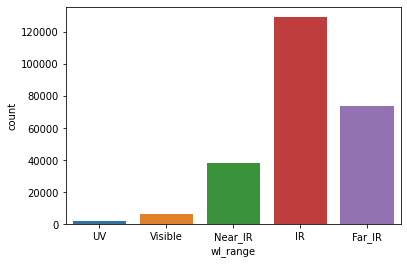

In [21]:
# Visualising
sns.countplot(x ='wl_range', data = df)

In [22]:
# Lets select only rows within UV-Vis
uv_visDF = df.loc[df['wl_range'].isin(['UV', 'Visible'])]

# drop the wl_range column
uv_visDF = uv_visDF.drop(['wl_range'], axis=1)
uv_visDF.head()

,book,wl,n,k
61,22,0.4465,1.368170,0.000000e+00
148,22,0.3916,1.373850,2.109850e-07
158,6,0.6850,1.411420,0.000000e+00
179,36,0.4850,1.362881,0.000000e+00
199,18,0.5011,1.345787,0.000000e+00


In [23]:
# Describe new uv_visDF with only UV-VIS data
uv_visDF.describe()

,book,wl,n,k
count,8075.000000,8075.000000,8075.000000,8075.000000
mean,25.754427,0.509479,1.414538,0.002962
std,16.040133,0.138818,0.120064,0.038937
min,0.000000,0.002000,0.837000,0.000000
25%,9.000000,0.414900,1.377863,0.000000
50%,22.000000,0.526300,1.417986,0.000000
75%,39.000000,0.615400,1.483392,0.000000
max,59.000000,0.750000,2.010000,0.809000


In [24]:
uv_visDF.shape

(8075, 4)

In [25]:
# Adding a single data to molecule with code 26, so as to have atleast 5 data points 
# which are required for our curve fitting per molecule
uv_visDF.loc[len(uv_visDF.index)] = [26, 0, 0, 0]

In [26]:
# Counting number of occurences per class of compounds
uv_visDF.groupby(['book'])['book'].count()

book
0       36
1       87
3       36
5      139
6     1248
7       36
8      101
9      341
10      51
11     317
13      61
14      87
15     101
17     101
18     129
19     101
20     504
21      88
22     514
23     101
24     101
25      59
26       5
27      78
28     441
30      48
31      28
32     101
34     144
35      56
36     303
37      28
38     482
39     404
41      23
42      28
43     303
45     152
46     303
48      84
49      51
50      35
51      35
52      35
53      51
55     217
56     159
57     120
59      23
Name: book, dtype: int64

In [27]:
# define the true objective function representing Sellmeier equation
# wl = wavelength, This is the same as x 
# A, B1, B2, C1 & C2 are coefficients to be optimized per molecule

def objective(x, A, B1, B2, C1, C2):
    
    return A + ((B1 * pow(x,2)) / ((pow(x,2)) - C1)) + ((B2 * pow(x,2)) / ((pow(x,2)) - C2))

In [28]:
# This function takes a molCode and returns Sellmeier equation coefficients

def coefficientsGenerator(molCode):
  # molDF = dataframe containing only rows for single molecule
  # molCode = molecule Code as per our encoding (0,1, 2 e.t.c)

  # Fiting our UV-VIS Data to obtain Sellmeier equation coefficients

  # creating a molDF for book with code molCode
  molDF = uv_visDF.loc[uv_visDF['book'] == molCode]

  # choose the input and output variables
  # x = wl, y = n-squared
  x, y = molDF['wl'], pow(molDF['n'], 2)
  # curve fit
  coefficients, _ = curve_fit(objective, x, y, maxfev=100000)

  # summarize the parameter values
  # we can get our coefficients by A, B1, B2, C1, C2 = coefficients
  return coefficients

In [29]:
# This function take the molCode and returns a df with augmented data in uv-vis 
def molAugmenter(molCode):
  # Our augMolDF - data generated will be appended here
  # molCode = book
  augMolDF = pd.DataFrame(columns = ['book', 'wl', 'n', 'k'])

  # Generate 5000 k values (filled with zeroes)
  k_list = [0 for i in range(5000)]

  # Generate 5000 book values (filled with molCode)
  book_list = [molCode for i in range(5000)]


  # call our coef generator, store returned data to variables
  A, B1, B2, C1, C2 = coefficientsGenerator(molCode)

  # Generate random data for molCode within UV-VIS range
  # 5000 data per molecule
  # we use 0 - 0.75 micrometres, not specifically accurate

  # Generate random wavelenths in the uv-vis range (wl)
  randValues = [random.uniform(0, 0.75) for x in range(5000)]
  wl_list = np.array(randValues)

  # calculate the output for the wl above (n2) using our objective function
  # then find the square root to get n (refractive index values)
  n_list = np.sqrt(objective(wl_list, A, B1, B2, C1, C2))

  # We have all lists for wl, book, k, and n
  # let's create a df and return it
  augMolDF['book'] = book_list
  augMolDF['wl'] = wl_list
  augMolDF['n'] = n_list
  augMolDF['k'] = k_list

  print('Finished generating data for book: ', molCode)
  # Return our populated dataframe for this molecule
  return augMolDF

In [30]:
# # Testing the molAugmenter
# molAugmenter(7)

Creating the uv_visAugmenter, it returns a purely generated dataframe which can be concatinates to uv-visDF

In [31]:
def uv_visAugmenter():
  # Our augUv_visDf - data of each molecule will be appended here
  augUV_visDf = pd.DataFrame(columns = ['book', 'wl', 'n', 'k'])

  # Get unique values of molecules in UV_VIS region
  uv_visMols = uv_visDF.book.unique().tolist()

  counter = 0 # keep track of books handled

  # Loop through the list and genete a df for each mole, then append it to augUv_visDf
  for mol in uv_visMols:
    # Call the mol augmenter, it returns a generated dataFrame with synthesized data
    df_per_mol = molAugmenter(mol)

    # Merge above df into our augUv_visDf
    augUV_visDf = pd.concat([augUV_visDf, df_per_mol])
    counter = counter + 1
    print('Finished working on ', counter , ' books')


  print('\nTotal books processed ; ', counter)
  # Return our final populated dataFrame   
  return augUV_visDf

In [32]:
# Merging the synthesized data to our original uv-vis dataframe
uv_visDF = pd.concat([uv_visDF, uv_visAugmenter()])

uv_visDF.describe()

Finished generating data for book:  22
Finished working on  1  books
Finished generating data for book:  6
Finished working on  2  books
Finished generating data for book:  36
Finished working on  3  books
Finished generating data for book:  18
Finished working on  4  books
Finished generating data for book:  19
Finished working on  5  books
Finished generating data for book:  0
Finished working on  6  books
Finished generating data for book:  9
Finished working on  7  books
Finished generating data for book:  28
Finished working on  8  books
Finished generating data for book:  48
Finished working on  9  books
Finished generating data for book:  27
Finished working on  10  books
Finished generating data for book:  43
Finished working on  11  books
Finished generating data for book:  38
Finished working on  12  books
Finished generating data for book:  15
Finished working on  13  books
Finished generating data for book:  23
Finished working on  14  books
Finished generating data for boo

,wl,n
count,253076.000000,252770.000000
mean,0.379311,1.712891
std,0.215457,1.613322
min,0.000000,0.000000
25%,0.194016,1.399663
50%,0.382112,1.479020
75%,0.565826,1.596736
max,0.750000,44.076235


**Creating uv_visAugmentedData csv from uv_visDF**

In [33]:
uv_visDF.isna().sum()

book      0
wl        0
n       306
k         0
dtype: int64

In [34]:
# Clean the dataframme by Dropping  rows with any null values
uv_visDF = uv_visDF.dropna(subset=['n'])

In [35]:
# Preview again
uv_visDF.isna().sum()

book    0
wl      0
n       0
k       0
dtype: int64

In [36]:
uv_visDF.describe()

,wl,n
count,252770.000000,252770.000000
mean,0.379741,1.712891
std,0.215232,1.613322
min,0.000000,0.000000
25%,0.194704,1.399663
50%,0.382628,1.479020
75%,0.566004,1.596736
max,0.750000,44.076235


In [37]:
uv_visDF.head()

,book,wl,n,k
61,22,0.4465,1.368170,0.0
148,22,0.3916,1.373850,0.0
158,6,0.6850,1.411420,0.0
179,36,0.4850,1.362881,0.0
199,18,0.5011,1.345787,0.0


In [38]:
uv_visDF.to_csv('./uv_visAugmentedData5000books.csv', index = False)